In [1]:
import pandas as pd
import numpy as np 

### Merging different sets of metrics in one dataframe

In [2]:
df1 = pd.read_csv('bug-metrics.csv')
df1 = df1.drop(columns = ['nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs'])
df2 = pd.read_csv('change-metrics.csv')
df2 = df2.drop(columns = ['nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs'])
df = pd.merge(df1, df2, on = ['classname','bugs'])
df3 = pd.read_csv('lin-ent.csv')
df3 = df3.drop(columns = ['nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs'])
df = pd.merge(df, df3, on = ['classname', 'bugs'] )
df4 = pd.read_csv('complexity-code-change.csv')
df = pd.merge(df, df4, on='classname')

In [3]:
def classification(to_convert):
    final_list=[]
    for i in to_convert:
        if i>0.08:
            final_list.append(1)
        else:
            final_list.append(0)
    return final_list

### Separating features and target and feature scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

# --> Debugging statements

from sklearn.model_selection import train_test_split
##print(df.columns)

# classname has no use and the unnamed column was created due to a wrongly placed space
# will clear it in the future
df = df.drop(columns=['classname'])

##print(df.dtypes)
df.dropna()

#Removing the actual bug count column to extract the metrics
X = df.loc[:, df.columns != 'bugs']
Y = df['bugs']

##print(X.dtypes)

X = X.apply(pd.to_numeric)
##print(X.head())
X_asDF = X

# Feature Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Y = [(float(i)-min(Y))/(max(Y)-min(Y)) for i in Y]



In [13]:
from collections import Counter
freq = Counter(classification(Y))
freq

Counter({0: 791, 1: 206})

### Extracting top 5 metrics and calculating Ru

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
feature_scores = {}
r_scores = []

from sklearn.linear_model import LinearRegression
import operator

reg = LinearRegression()

for i in range(X_train.shape[1]):
    reg.fit(X_train[:,i].reshape(-1,1),Y_train)
    feature_scores[i] = reg.score(X_train[:,i].reshape(-1,1),Y_train)

sorted_feature_scores = dict(sorted(feature_scores.items(), key=operator.itemgetter(1),reverse=True))


dict_items = sorted_feature_scores.items()

top_n_metrics = list(dict_items)[:5]
print(top_n_metrics)
#print(X_asDF.columns[top_n_metrics[0][0]])

list_keys = [x[0] for x in top_n_metrics]
print(X_asDF.columns[list_keys])
#print(list_keys)
X_train_for_multiple  = X_train[:,list_keys]
X_test_for_multiple  = X_test[:,list_keys]
reg.fit(X_train_for_multiple, Y_train)

rU = reg.score(X_train_for_multiple, Y_train)
print(rU)

[(36, 0.49975875178300944), (1, 0.49731878628446335), (35, 0.4933871953545449), (28, 0.4889526220296804), (0, 0.48747729447907007)]
Index(['wmc', 'numberOfNonTrivialBugsFoundUntil:', 'rfc',
       'numberOfLinesOfCode', 'numberOfBugsFoundUntil:'],
      dtype='object')
0.5490264761576464


### Applying proposed algorithm with Polynomial Regression

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X)


poly.fit(X_poly,Y)
X_train, X_test, Y_train, Y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=1)
feature_scores = {}
r_scores = []

# Fitting Polynomial Regression to the dataset

from sklearn.linear_model import LinearRegression, Lasso
import operator

reg = LinearRegression() 
for i in range(X_train.shape[1]):
    reg.fit(X_train[:,i].reshape(-1,1),Y_train)
    feature_scores[i] = reg.score(X_train[:,i].reshape(-1,1),Y_train)

sorted_feature_scores = dict( sorted(feature_scores.items(), key=operator.itemgetter(1),reverse=True))


dict_items = sorted_feature_scores.items()

top_n_metrics = list(dict_items)[:5]
#print(top_n_metrics)
#print(X_asDF.columns[top_n_metrics[0][0]])

list_keys = [x[0] for x in top_n_metrics]
#print(list_keys)
X_train_for_multiple  = X_train[:,list_keys]
X_test_for_multiple  = X_test[:,list_keys]
reg.fit(X_train_for_multiple, Y_train)

rU = reg.score(X_train_for_multiple, Y_train)
print(rU)

0.5531120727134429


### Proposed Algorithm with Lasso Regression

In [8]:
feature_scores = {}
r_scores = []

# Fitting Polynomial Regression to the dataset

from sklearn.linear_model import LinearRegression, Lasso, Ridge
import operator

reg = Ridge() 
for i in range(X_train.shape[1]):
    reg.fit(X_train[:,i].reshape(-1,1),Y_train)
    feature_scores[i] = reg.score(X_train[:,i].reshape(-1,1),Y_train)

sorted_feature_scores = dict(sorted(feature_scores.items(), key=operator.itemgetter(1),reverse=True))

dict_items = sorted_feature_scores.items()

top_n_metrics = list(dict_items)[:5]

list_keys = [x[0] for x in top_n_metrics]

X_train_for_multiple  = X_train[:,list_keys]
X_for_proposed = X[:,list_keys]
X_test_for_multiple  = X_test[:,list_keys]
reg.fit(X_train_for_multiple, Y_train)

rU = reg.score(X_train_for_multiple, Y_train)
print(rU)

IndexError: index 926 is out of bounds for axis 1 with size 42

### Calculating weights for the selected features

In [15]:
d = []
for i in list_keys:
    remaining_features = [j for j in list_keys if j != i ]
    X_train_remaining = X_train[:,remaining_features]
    X_test_remaining = X_test[:,remaining_features]
    reg.fit(X_train_remaining, Y_train)
    train_score = reg.score(X_train_remaining, Y_train)
    print(train_score)
    d.append(rU-train_score)

0.5404712079771785
0.5421514586147131
0.5458549186309055
0.548752196228031
0.546266253482119


### Normalising weights for and predicting the bug proneness index

In [16]:
norm_d = [(float(i)-min(d))/(max(d)-min(d)) for i in d]
print(norm_d)
#Weights should be mapped to elements in the list_keys
#norm_d are the normalized weights of the n metrics

    
  

[1.0, 0.7970953965111994, 0.3498709947846131, 0.0, 0.30019880123076625]


### Printing the predicted and the actual target

In [17]:
## The paper doesn't mention normalising again but some values don't lie in the range of 0 to 1
## Hence normalising again
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
Y_pred_final = [round(i,4) for i in Y_pred]
Y_test_final = [round(i,4) for i in Y_test]
for(predicted, actual) in zip(Y_pred_final, Y_test_final):
    print(f"{predicted} - {actual}") 
    print()

0.5328 - 0.1111

0.0169 - 0.0

0.185 - 0.0

0.0 - 0.0

0.0128 - 0.0

0.0006 - 0.0

0.0047 - 0.0

0.0874 - 0.1111

0.0024 - 0.0

0.0349 - 0.0

0.0071 - 0.0

0.0196 - 0.0

0.0 - 0.1111

0.0 - 0.0

0.0131 - 0.0

0.0071 - 0.1111

0.0172 - 0.0

0.0101 - 0.0

0.0508 - 0.0

0.0 - 0.0

0.0024 - 0.0

0.0192 - 0.0

0.0573 - 0.2222

0.0024 - 0.0

0.0139 - 0.0

0.0 - 0.0

0.0406 - 0.0

0.1552 - 0.0

0.0024 - 0.0

0.0965 - 0.0

0.0 - 0.0

0.0024 - 0.0

0.0144 - 0.0

0.0518 - 0.0

0.1261 - 0.0

0.0213 - 0.0

0.0077 - 0.0

0.0342 - 0.0

0.0024 - 0.0

0.0 - 0.0

0.0 - 0.2222

0.0231 - 0.0

0.1525 - 0.0

0.0676 - 0.0

0.1014 - 0.0

0.0102 - 0.0

0.1016 - 0.1111

0.032 - 0.0

0.277 - 0.4444

0.1871 - 0.4444

0.0238 - 0.1111

0.0359 - 0.1111

0.0071 - 0.0

0.0 - 0.0

0.0179 - 0.0

0.0449 - 0.0

0.0 - 0.0

0.0439 - 0.0

0.0125 - 0.1111

0.1912 - 0.2222

0.0 - 0.0

0.1995 - 0.5556

0.0366 - 0.0

0.0 - 0.0

0.0256 - 0.0

0.4213 - 0.1111

0.0136 - 0.0

0.0095 - 0.0

0.0 - 0.0

0.0047 - 0.0

0.106 - 0.1111

0

In [18]:
## For comparison and visualization 
# For Linear
print(Y_pred[:5])

[0.5327692852842281, 0.01690233241257171, 0.18495033531538796, 0.0, 0.012806328811375587]


In [19]:
print(Y_test[:20])

[0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0]


In [20]:
df.head()

,numberOfBugsFoundUntil:,numberOfNonTrivialBugsFoundUntil:,numberOfMajorBugsFoundUntil:,numberOfCriticalBugsFoundUntil:,numberOfHighPriorityBugsFoundUntil:,bugs,numberOfVersionsUntil:,numberOfFixesUntil:,numberOfRefactoringsUntil:,numberOfAuthorsUntil:,...,numberOfPrivateMethods,numberOfPublicAttributes,numberOfPublicMethods,rfc,wmc,CvsEntropy,CvsWEntropy,CvsLinEntropy,CvsLogEntropy,CvsExpEntropy
0,3,2,0,0,0,0,65,4,0,8,...,0.0,0.000000,0.000000,0.000000,0.000000,10.91310,0.008302,0.014767,0.253257,0.001125
1,0,0,0,0,0,0,2,0,0,2,...,0.0,0.000000,0.000000,0.000000,0.000000,1.10349,0.000657,0.001886,0.027116,0.000351
2,55,48,6,4,2,1,120,10,0,12,...,0.0,0.000000,0.000905,0.036114,0.041101,37.86060,0.228509,0.106180,1.028400,0.210412
3,3,3,0,0,0,0,28,4,0,5,...,0.0,0.000000,0.001756,0.002711,0.002314,5.86013,0.009105,0.010113,0.143680,0.003485
4,15,13,1,1,0,0,93,17,0,8,...,0.0,0.000695,0.000000,0.003749,0.001594,13.59600,0.016005,0.025751,0.338602,0.021378


In [ ]:
!pip install imblearn

## Function to classify bug count to 0 or 1

In [ ]:
from imblearn.over_sampling import SMOTE
Y_train_classified = classification(Y_train)
Y_test_classified = classification(Y_test)
Y_pred_classified=classification(Y_pred_final)

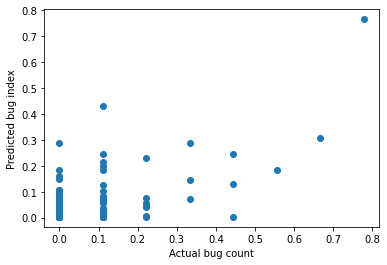

In [22]:
# Plotting of simple linear regression model

import matplotlib.pyplot as plt
X_train_for_singlefeat = X_train[:,list_keys[0]]
X_single_feat = X[:,list_keys[0]]
X_single_feat_2d = X_single_feat.reshape(-1,1)
X_test_for_singlefeat = X_test[:,list_keys[0]]
X_train_for_singlefeat_2d = X_train_for_singlefeat.reshape(-1,1)
reg.fit(X_train_for_singlefeat_2d,Y_train)
X_test_for_singlefeat_2d = X_test_for_singlefeat.reshape(-1,1)
Y_Predicted = reg.predict(X_test_for_singlefeat_2d)
plt.xlabel("Actual bug count")
plt.ylabel("Predicted bug index")
plt.scatter(Y_test_final,Y_Predicted)

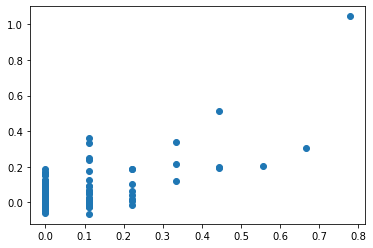

In [23]:
# Plotting of multiple linear regression

reg.fit(X_train,Y_train)
Y_Pred_multiplereg = reg.predict(X_test)
plt.scatter(Y_test,Y_Pred_multiplereg)

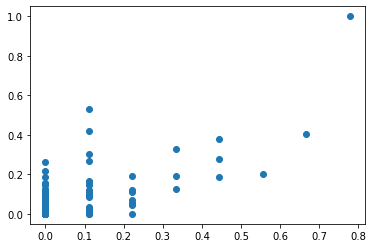

In [24]:
# Plotting of prosposed model

plt.scatter(Y_test_final,Y_pred_final)

## Classificaton report for testing data
### Simple Linear regression

In [25]:
reg.fit(X_train_for_singlefeat_2d,Y_train)
Y_pred_simple = reg.predict(X_test_for_singlefeat_2d)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred_simple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       159
           1       0.63      0.41      0.50        41

    accuracy                           0.83       200
   macro avg       0.75      0.68      0.70       200
weighted avg       0.81      0.83      0.82       200



### Multiple Linear regression

In [26]:
reg.fit(X_train,Y_train)
Y_pred_multiple = reg.predict(X_test)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred_multiple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       159
           1       0.59      0.49      0.53        41

    accuracy                           0.82       200
   macro avg       0.73      0.70      0.71       200
weighted avg       0.82      0.82      0.82       200



### Proposed model

In [28]:
Y_pred = []
for features_test in X_test:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features_test[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       159
           1       0.62      0.61      0.62        41

    accuracy                           0.84       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.84      0.84      0.84       200



In [ ]:
# Accuracy - 3 
# Precision - 3
# Recall - 3
# F measure - 3

### Classification report for Training Data

### Simple Linear Regression

In [30]:
reg.fit(X_train_for_singlefeat_2d,Y_train)
Y_pred_simple = reg.predict(X_train_for_singlefeat_2d)
print("Classification report : ")
print(classification_report(classification(Y_train), classification(Y_pred_simple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       632
           1       0.66      0.48      0.56       165

    accuracy                           0.84       797
   macro avg       0.77      0.71      0.73       797
weighted avg       0.83      0.84      0.83       797



### Multiple Linear Regression

In [31]:
reg.fit(X_train,Y_train)
Y_pred_multiple = reg.predict(X_train)
print("Classification report : ")
print(classification_report(classification(Y_train), classification(Y_pred_multiple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       632
           1       0.71      0.53      0.61       165

    accuracy                           0.86       797
   macro avg       0.80      0.74      0.76       797
weighted avg       0.85      0.86      0.85       797



### Proposed Model

In [29]:
Y_pred = []
for features_train in X_train:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features_train[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
print("Classification report : ")
print(classification_report(classification(Y_train), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       632
           1       0.64      0.58      0.61       165

    accuracy                           0.85       797
   macro avg       0.77      0.75      0.76       797
weighted avg       0.84      0.85      0.84       797



In [ ]:
# Accuracy - 2
# Precision - 2
# Recall - 2
# F measure - 2

### Classification Report for overall data

### Simple Linear Regression

In [33]:
reg.fit(X_train_for_singlefeat_2d,Y_train)
Y_pred_simple = reg.predict(X_single_feat_2d)
print("Classification report : ")
print(classification_report(classification(Y), classification(Y_pred_simple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       791
           1       0.66      0.47      0.55       206

    accuracy                           0.84       997
   macro avg       0.76      0.70      0.73       997
weighted avg       0.83      0.84      0.83       997



### Multiple Linear Regression

In [34]:
reg.fit(X_train,Y_train)
Y_pred_overall = reg.predict(X)
print("Classification report : ")
print(classification_report(classification(Y), classification(Y_pred_overall)))

Classification report : 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       791
           1       0.69      0.52      0.59       206

    accuracy                           0.85       997
   macro avg       0.78      0.73      0.75       997
weighted avg       0.84      0.85      0.84       997



### Proposed Model

In [32]:
Y_pred = []
for features in X:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
print("Classification report : ")
print(classification_report(classification(Y), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       791
           1       0.64      0.59      0.61       206

    accuracy                           0.85       997
   macro avg       0.77      0.75      0.76       997
weighted avg       0.84      0.85      0.84       997



In [ ]:
# Accuracy - 3
# Precision - 2
# Recall - 3
# F measure - 3

In [48]:

f1_simple = [0.82,0.83,0.83]
acc_simple = [0.83,0.84,0.84]
prec_simple = [0.81,0.83,0.83]
rec_simple = [0.83,0.84,0.84]

f1_multiple = [0.82,0.85,0.84]
acc_multiple = [0.82,0.86,0.85]
prec_multiple = [0.82,0.85,0.84]
rec_multiple = [0.82,0.86,0.85]

f1_proposed = [0.84,0.84,0.84]
acc_proposed = [0.84,0.85,0.85]
prec_proposed = [0.84,0.84,0.84]
rec_proposed = [0.84,0.85,0.85]

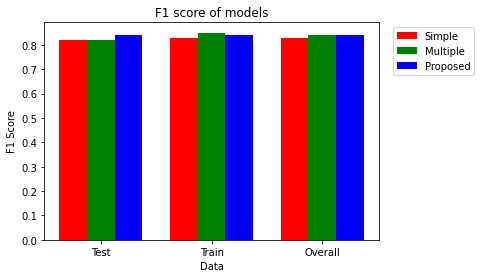

In [64]:
N = 3
ind = np.arange(N) 
width = 0.25  
bar1 = plt.bar(ind, f1_simple, width, color = 'r')
bar2 = plt.bar(ind+width, f1_multiple, width, color='g')
bar3 = plt.bar(ind+width*2, f1_proposed, width, color = 'b')
  
plt.xlabel("Data")
plt.ylabel("F1 Score")
plt.title("F1 score of models")
  
plt.xticks(ind+width,['Test', 'Train', 'Overall'])
plt.legend( (bar1, bar2, bar3), ('Simple', 'Multiple', 'Proposed'),bbox_to_anchor =(1.3, 1.0) )
plt.show()

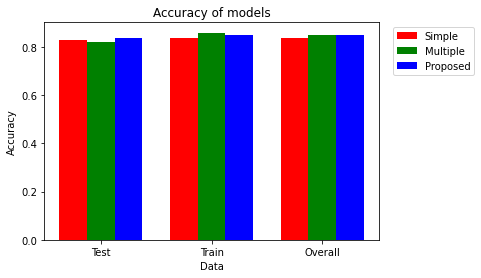

In [74]:
N = 3
ind = np.arange(N) 
width = 0.25  
bar1 = plt.bar(ind, acc_simple, width, color = 'r')
bar2 = plt.bar(ind+width, acc_multiple, width, color='g')
bar3 = plt.bar(ind+width*2, acc_proposed, width, color = 'b')
  
plt.xlabel("Data")
plt.ylabel("Accuracy")
plt.title("Accuracy of models")
  
plt.xticks(ind+width,['Test', 'Train', 'Overall'])
plt.legend( (bar1, bar2, bar3), ('Simple', 'Multiple', 'Proposed'),bbox_to_anchor =(1.3, 1.0) )
plt.show()

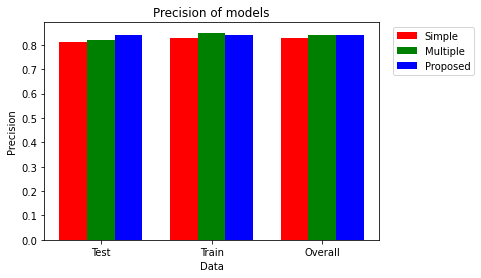

In [75]:
N = 3
ind = np.arange(N) 
width = 0.25  
bar1 = plt.bar(ind, prec_simple, width, color = 'r')
bar2 = plt.bar(ind+width, prec_multiple, width, color='g')
bar3 = plt.bar(ind+width*2, prec_proposed, width, color = 'b')
  
plt.xlabel("Data")
plt.ylabel("Precision")
plt.title("Precision of models")
  
plt.xticks(ind+width,['Test', 'Train', 'Overall'])
plt.legend( (bar1, bar2, bar3), ('Simple', 'Multiple', 'Proposed'),bbox_to_anchor =(1.3, 1.0) )
plt.show()

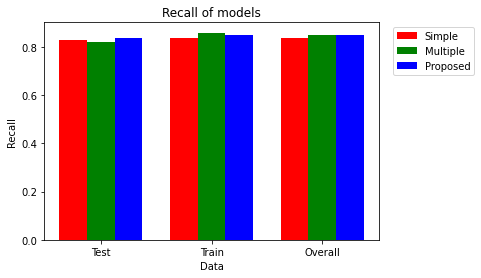

In [76]:
N = 3
ind = np.arange(N) 
width = 0.25  
bar1 = plt.bar(ind, rec_simple, width, color = 'r')
bar2 = plt.bar(ind+width, rec_multiple, width, color='g')
bar3 = plt.bar(ind+width*2, rec_proposed, width, color = 'b')
  
plt.xlabel("Data")
plt.ylabel("Recall")
plt.title("Recall of models")
  
plt.xticks(ind+width,['Test', 'Train', 'Overall'])
plt.legend( (bar1, bar2, bar3), ('Simple', 'Multiple', 'Proposed'),bbox_to_anchor =(1.3, 1.0) )
plt.show()

### Applying classification models to the proposed model(5 selected features)

In [35]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB,ComplementNB
Y = df['bugs']
Y_nb = []
print(set(Y))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [36]:
from imblearn.over_sampling import SMOTE
clf = GaussianNB()
sm = SMOTE(random_state = 2)
Y_train_classified = classification(Y_train)
Y_test_classified = classification(Y_test)
X_train_res, Y_train_res = sm.fit_resample(X_train_for_multiple, Y_train_classified)
X_test_res, Y_test_res = sm.fit_resample(X_test_for_multiple, Y_test_classified)
print(Counter(Y_train_res))
clf.fit(X_train_res, Y_train_res)
Y_pred = clf.predict(X_test_res)
from sklearn.metrics import accuracy_score,classification_report
print("Classification report : ")
print(classification_report(classification(Y_test_res), classification(Y_pred)))

Counter({0: 632, 1: 632})
Classification report : 
              precision    recall  f1-score   support

           0       0.67      0.92      0.78       159
           1       0.88      0.54      0.67       159

    accuracy                           0.73       318
   macro avg       0.77      0.73      0.72       318
weighted avg       0.77      0.73      0.72       318



In [37]:
clf = ComplementNB()
clf.fit(X_train_for_multiple, classification(Y_train))
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       159
           1       0.30      0.56      0.39        41

    accuracy                           0.64       200
   macro avg       0.58      0.61      0.57       200
weighted avg       0.74      0.64      0.67       200



In [38]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = "entropy", splitter="random",min_samples_split=3)
clf.fit(X_train_res, Y_train_res)
print(Counter(Y_train_res))
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Counter({0: 632, 1: 632})
Classification report : 
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       159
           1       0.41      0.39      0.40        41

    accuracy                           0.76       200
   macro avg       0.63      0.62      0.62       200
weighted avg       0.76      0.76      0.76       200



In [39]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='saga', penalty = 'l2', C = 0.1, random_state=10)
clf.fit(X_train_res, Y_train_res)
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       159
           1       0.64      0.61      0.62        41

    accuracy                           0.85       200
   macro avg       0.77      0.76      0.77       200
weighted avg       0.85      0.85      0.85       200



In [40]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=35)
clf.fit(X_train_res, Y_train_res)
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       159
           1       0.47      0.76      0.58        41

    accuracy                           0.78       200
   macro avg       0.70      0.77      0.71       200
weighted avg       0.83      0.78      0.79       200



In [41]:
from sklearn.ensemble import RandomForestClassifier
rfs = RandomForestClassifier(n_estimators=300, criterion = "gini")
rfs.fit(X_train_res, Y_train_res)
Y_pred = rfs.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       159
           1       0.49      0.46      0.48        41

    accuracy                           0.79       200
   macro avg       0.68      0.67      0.67       200
weighted avg       0.79      0.79      0.79       200



In [42]:
Counter(Y_train_classified)
print(X_train)

[[0.         0.         0.         ... 0.02088787 0.01043805 0.00177681]
 [0.01401869 0.005      0.         ... 0.05292446 0.01730772 0.05042487]
 [0.06542056 0.065      0.05263158 ... 0.10292228 0.04406022 0.04115889]
 ...
 [0.14953271 0.145      0.10526316 ... 0.61903227 0.91153662 0.50895073]
 [0.03738318 0.035      0.         ... 0.51903798 0.87449154 0.40012858]
 [0.02336449 0.01       0.         ... 0.14018949 0.01443694 0.24466886]]
